# Image Processing and Computing the Mean Curvature of Objects in .tif File Images

Here, we load `.tif` file images into python. The loaded files are visualized in subplots as seperate channels in which each channel can have the following properities modified: `brightness`, `contrast`, `gain`, and `bias`. 

The image of the given channel is then masked and segmented. We focused on the image files 'blobs.tif' and 'FluorescentCells.tif' for this pilot code, with the latter primarily focusing on the third channel containing the fluorescently labeled cells' nuclei. In the code, they are referred to as `img1` and `img2[2]`, where `[2]` denotes the third channel.

Finally, we compute the mean curvature of each blob using the masked image channel. 

## Importing packages and modules implemented in the code

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap                                      # Colormap objects based on lookup tables using linear segments
from skimage import data, io, filters, measure, segmentation, feature, morphology, viewer  # A collection of algorithms for image processing
from scipy import ndimage as ndi                                                           # A collection of functions for multidimensional image processing
from skimage.segmentation import clear_border as clear_border                              # Create a checkerboard level set with binary values
from skimage.measure import label, regionprops                                             


import masking_mod as mskf #the module we made to segment tif images 
import curvature_module as crvf #the module to detect curvature 
import counting_module

## Loading and visualizing images from .tif file format


In [12]:
## Load images
img1 = io.imread("Images/blobs.tif", plugin="tifffile")
img2 = io.imread("Images/FluorescentCells.tif", plugin="tifffile").T  # .T to transpose image with multple channels (x, y, z) -> (z, y, x)
img3 = io.imread("Images/FluorescentCells2.tif", plugin="tifffile").T # .T to transpose image with multple channels (x, y, z) -> (z, y, x)

#ch1, ch2, ch3 = img2[0], img2[1], img2[2]

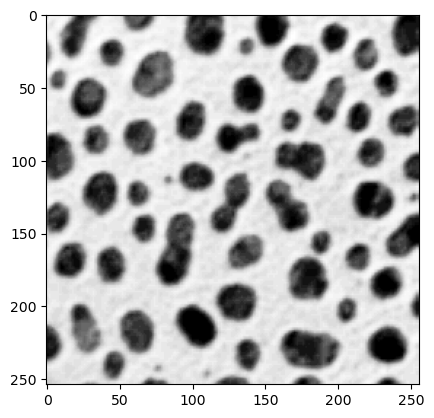

In [13]:
## Visualize the channels of the image as seperate channels in a subplot
plt.imshow(img1, cmap="Greys")
plt.show()

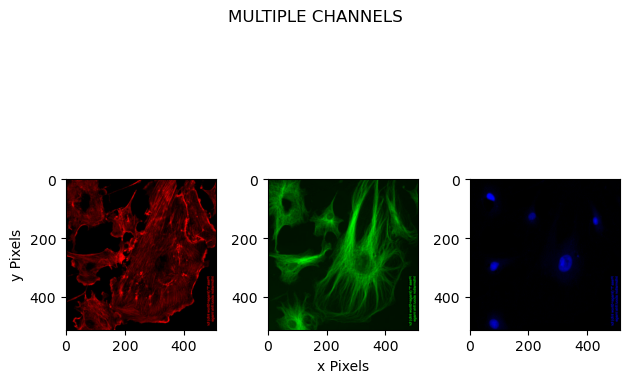

In [14]:
## Setting color dictionaries for visualization
red = [(0, 0, 0), (1, 0, 0)]
green = [(0, 0, 0), (0, 1, 0)]
blue = [(0, 0, 0), (0, 0, 1)]
yellow = [(0, 0, 0), (1, 1, 0)]
magenta = [(0, 0, 0), (1, 0, 1)]
cyan = [(0, 0, 0), (0, 1, 1)]

## setting color maps for visualization
lut_red = LinearSegmentedColormap.from_list("Custom", red, N=256)
lut_green = LinearSegmentedColormap.from_list("Custom", green, N=256)
lut_blue = LinearSegmentedColormap.from_list("Custom", blue, N=256)
lut_cyan = LinearSegmentedColormap.from_list("Custom", cyan, N=256)
lut_magenta = LinearSegmentedColormap.from_list("Custom", magenta, N=256)
lut_yellow = LinearSegmentedColormap.from_list("Custom", yellow, N=256)

## Subplot for the 3 channels in img2 
fig, axs = plt.subplots(1, 3)
fig.suptitle("MULTIPLE CHANNELS")
axs[0].imshow(img2[0], cmap=lut_red)
axs[0].set_ylabel('y Pixels')
axs[1].imshow(img2[1], cmap=lut_green)
axs[1].set_xlabel('x Pixels')
axs[2].imshow(img2[2], cmap=lut_blue)
fig.tight_layout()
plt.show()

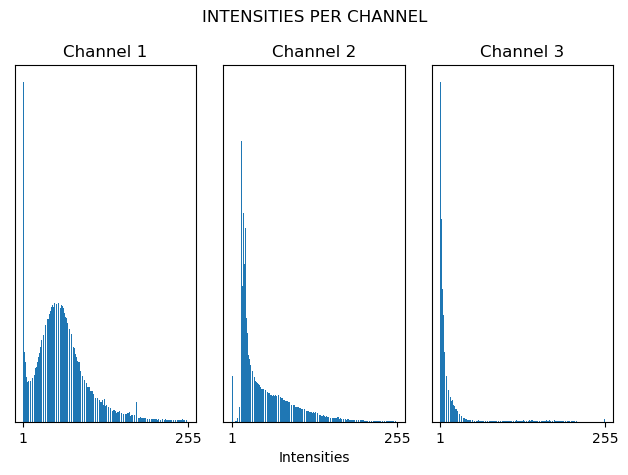

In [59]:
hist1 = np.histogram(img2[0], bins=255)
hist2 = np.histogram(img2[1], bins=255)
hist3 = np.histogram(img2[2], bins=255)

## Plots the associated intensity histagrams
fig1, axs = plt.subplots(1, 3)
fig1.suptitle("INTENSITIES PER CHANNEL")
axs[0].bar(hist1[1][1:-1], hist1[0][1:])
axs[0].set_title('Channel 1')
#axs[0].set_ylabel('Counts')
axs[0].set_yticks([])
axs[0].set_xticks([1, 255])

axs[1].bar(hist2[1][1:-1], hist2[0][1:])
axs[1].set_title('Channel 2')
axs[1].set_xlabel('Intensities')
axs[1].set_yticks([])
axs[1].set_xticks([1, 255])

axs[2].bar(hist3[1][1:-1], hist3[0][1:])
axs[2].set_title('Channel 3')
axs[2].set_yticks([])
axs[2].set_xticks([1, 255]);
fig1.tight_layout()
plt.show()

### Changing brightness and contrast
For each pixel `f` with coordenates `(i,j)` the function to change brightness and contrast is:

$$g(i,j)=\alpha\cdot f(i,j) + \beta$$

where $\alpha$ is the gain and $\beta$ is the bias.
$\alpha$ should be and interger equal or greater than zero and $\beta$ an interger.

Changing $\alpha$ changes the contrast of the image by making dark pixels darker and light pixels ligther, while changing $\beta$ changes the brightness, by making all pixels equally brighter or darker. 

https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

In [53]:
def change_brightness_contrast_linear(alpha, beta, channel):
    intensity_array = np.linspace(0,255,256)
    # histograms of the pixels' intensities in the original image
    hist = np.histogram(channel, bins=255) 
    alpha, beta, gamma = float(alpha), int(beta), float(alpha)
    # the transformation function g(i,j) presented above
    new_intensities = channel - beta 
    # x is the new minimum intesity set by the gain, the maximun values is 255-x.
    x = (255-(255/alpha))*0.5  
    
    # rounds up or down the intensities values that are outside the [x,255-x] domain of new intensities.
    if beta <= 0: 
        new_intensities[new_intensities<=x]=x
        new_intensities[new_intensities>=255-x]=255-x
    else:
        new_intensities[new_intensities>=255-beta]=0
        
    hist_new_intensities = np.histogram(new_intensities, bins=255)
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(10.5, 10.5)
    axs[0][0].set_title("Original")
    axs[0][0].imshow(channel, cmap=lut_red)
    axs[0][0].set_xticks([])
    axs[0][0].set_yticks([])
    axs[0][1].set_title("Contrast and brigthness changed")
    new_red = [(-beta / 256, 0, 0), (1, 0, 0)]
    new_lut_red = LinearSegmentedColormap.from_list("Custom", new_red, N=255)
    axs[0][1].imshow(new_intensities, cmap=new_lut_red)
    axs[0][1].set_xticks([])
    axs[0][1].set_yticks([])
    axs[1][0].bar(hist[1][1:-1],hist[0][1:])
    axs[1][0].set_xticks([1, 255])
    
    axs[1][1].bar(hist_new_intensities[1][1:-1],hist_new_intensities[0][1:])
    axs[1][1].set_xticks([1,255])
    axs[1][1].set_xlim(-10,265)

Gain: 1
Bias: -10


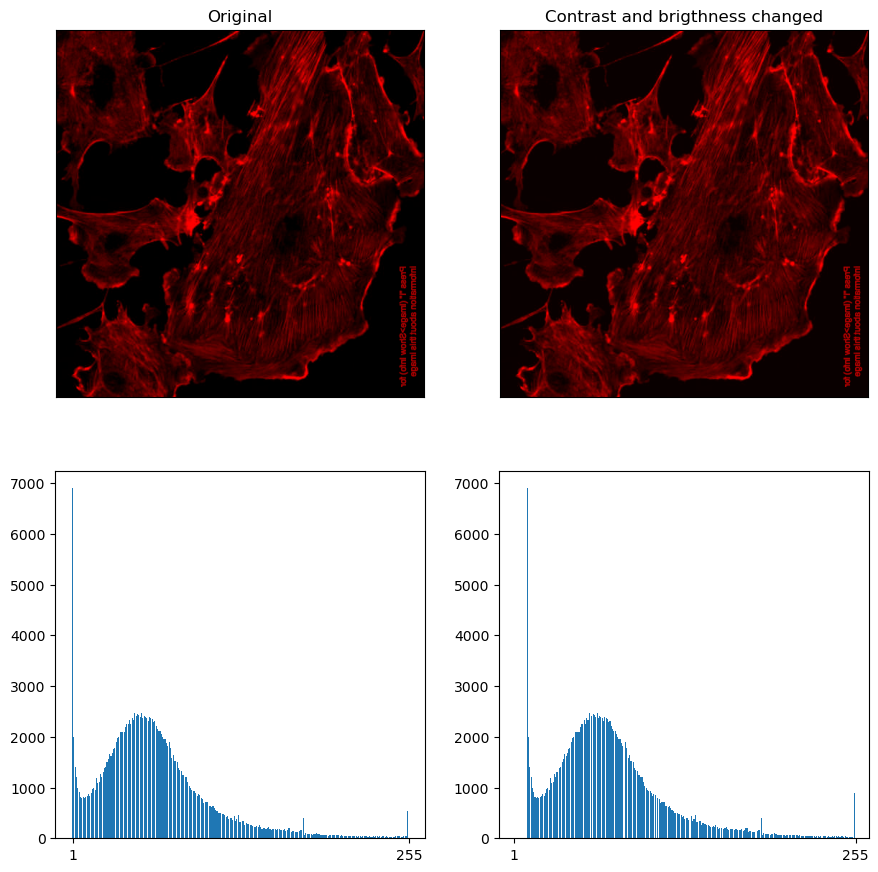

In [54]:
alpha = input("Gain:")
beta = input("Bias:")

change_brightness_contrast_linear(alpha, beta, img2[0])

Changing the brightness and contrast with a linear transformation can easily saturate the images. 
The \textbf{Gamma correction} 
$$g(i,j)=\left ( \frac{f(i,j)}{255} \right )^{\gamma}\times 255$$
will change the intensity of the pixel, depending on the original intesity of he pixel itself. 

If $\gamma<1$, the histogram shifts to the right. 
If $\gamma>1$, the histogram shift to theleft.

https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

In [55]:
# similar to the function change_brightness_contrast_linear, but with a gamma function
def gamma_transformation(gamma, channel):
    intensity_array = np.linspace(0,255,256)
    # histograms of the pixels' intensities in the original image
    hist = np.histogram(channel, bins=255) 
    gamma = float(gamma)
    # the transformation function g(i,j) presented above
    new_intensities = 255*((channel/255)**(gamma))
    
    new_intensities[new_intensities<=0]=0
    new_intensities[new_intensities>=255]=255
        
    hist_new_intensities = np.histogram(new_intensities, bins=255)

    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(10.5, 10.5)
    axs[0][0].set_title("Original")
    axs[0][0].imshow(channel, cmap=lut_red)
    axs[0][0].set_xticks([])
    axs[0][0].set_yticks([])
    axs[0][1].set_title("Contrast and brigthness changed")
    axs[0][1].imshow(new_intensities, cmap=lut_red)
    axs[0][1].set_xticks([])
    axs[0][1].set_yticks([])
    axs[1][0].bar(hist[1][1:-1],hist[0][1:])
    axs[1][0].set_xticks([1, 255])
    
    axs[1][1].bar(hist_new_intensities[1][1:-1],hist_new_intensities[0][1:])
    axs[1][1].set_xticks([1,255])

Gamma: 0.3


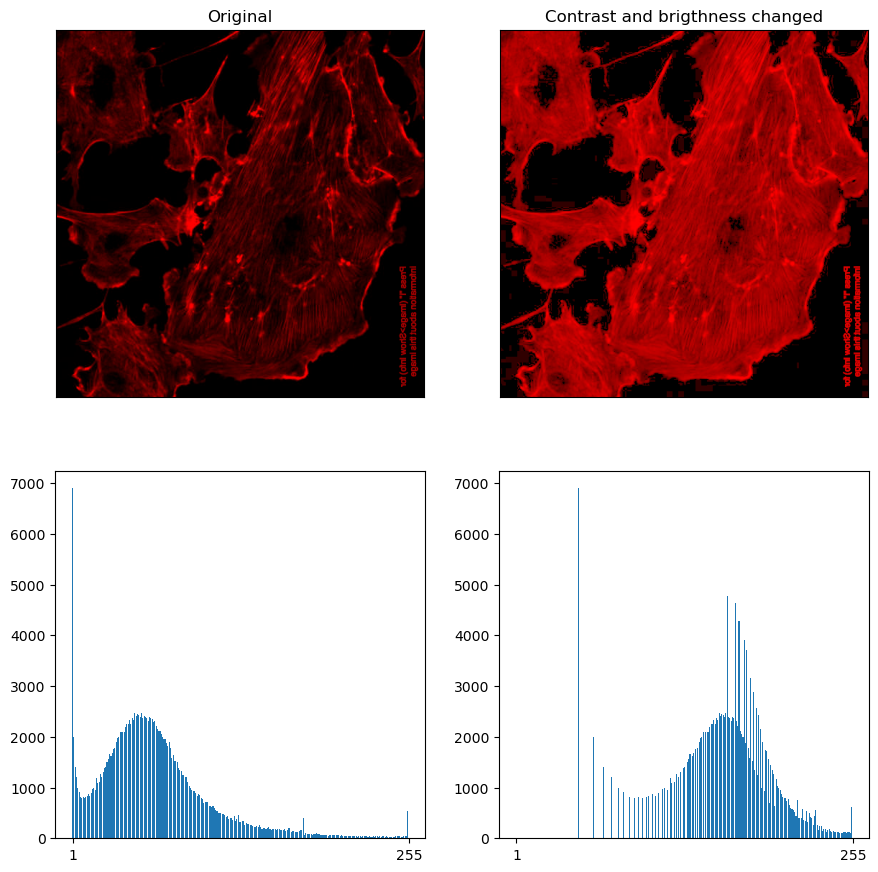

In [58]:
gamma = input("Gamma:")

gamma_transformation(gamma, img2[0])

## Segment and mask the image
The original code for the masking module (`masking_mod.py`) can be found at: 

- [image_processing1.ipynb](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Tutorial%20Series/image_processing1.ipynb)


In [ ]:
num_objects, object_sizes, filtered_img = counting_module.identify_objects_above_threshold(img1, 100, 500)
print(f'Number of identified objects: {num_objects}')
print(f'Size of identified objects: {object_sizes}')
plt.imshow(filtered_img)

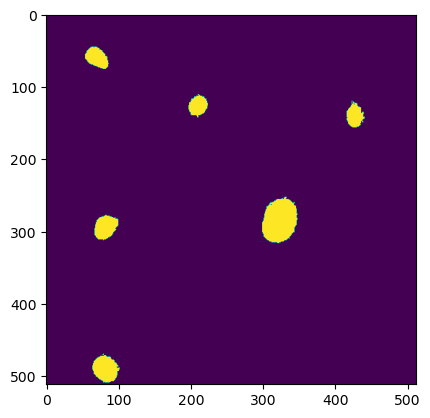

In [8]:
## Use masking function on specified image
img2_ch3_masked = mskf.masking(img2[2], threshold=50, num_labels=6)#(img2[2]

## Visualize the mask on the image
plt.imshow(img2_ch3_masked)

## Calculate the mean curvature

To calculate the curvate we implement module `curvature_module.py`. The code has been adapted from:

- [Exercise 11 - Segmentation](https://ojskrede.github.io/inf4300/exercises/week_11/)

- [Identifying and Measuring the Curvature of Caulobacter Cells](https://github.com/jmschabdach/caulobacter-curvature/blob/master/Identifying%20and%20Measuring%20the%20Curvature%20of%20Caulobacter%20Cells.ipynb)

- [Python edge detection and curvature calculation](https://stackoverflow.com/questions/9137216/python-edge-detection-and-curvature-calculation)

- [Scikit-Image: Image filtering](https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html)

- [Image Segmentation using Python’s scikit-image module.](https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980)   

/home/learner/curvature_module.py:63: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = feature.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=cleaned_edges)


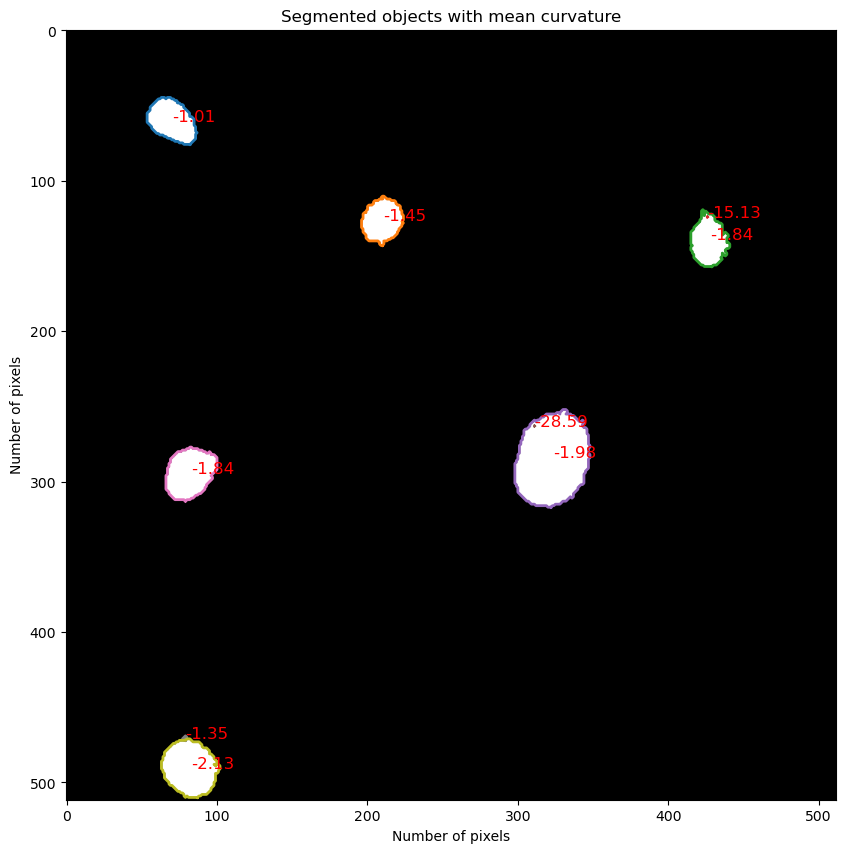

In [9]:
## Detecting edges for empty blobs using a Gaussian smoothing
#cleaned_edges = crvf.preprocess_image(img1, sigma=3, dilation_radius=1, min_size=100)

## Plotting the img2[2] with solid blobs using the segmentation and mask from above
cleaned_labels = crvf.segment_objects(img2_ch3_masked)
crvf.plot_segmented_objects(img2_ch3_masked, cleaned_labels, contour_threshold=0.5)

/home/learner/curvature_module.py:46: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  dilated_edges = morphology.dilation(edges, selem=morphology.disk(dilation_radius))


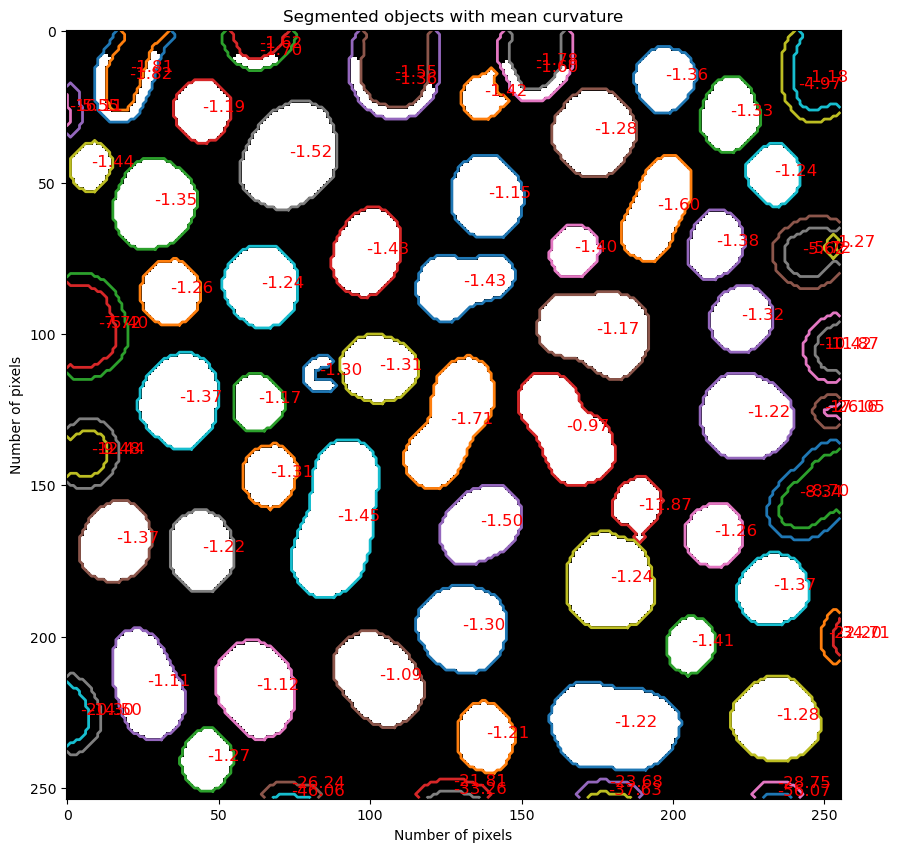

In [10]:
## Detecting edges for empty blobs using a Gaussian smoothing with the segmentation mask
cleaned_edges = crvf.preprocess_image(img1, sigma=3, dilation_radius=1, min_size=10)
cleaned_labels_img1 = crvf.segment_objects(cleaned_edges)
img1_masked = mskf.masking(cleaned_labels_img1, threshold=20, num_labels=-1)


## Plot the image with blobs (img1) using the segmentation and mask from above and the original image is below
crvf.plot_segmented_objects(img1_masked, cleaned_labels_img1, contour_threshold=0.5)